# Breaking the Columbia River into segments

In [18]:
import geopandas as gpd
import fiona
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import split, snap
from shapely.geometry import LineString, Point
import pandas as pd

In [19]:
# specify the project directory and file paths
proj_dir = Path("../") # base folder for the project
geopackage_fn = proj_dir / "Data/col_drivt_data.gpkg" # specify the path to the geopackage file
geopackage_fn = proj_dir / "Data/col_drivt_data.gpkg" # specify the path to the geopackage file
grwl_fn = proj_dir / "Data/GRWL_summaryStats_V01.01/GRWL_summaryStats.shp" # specify the path to the GRWL file
grand_reservoir_fn = proj_dir / "Data/GRanD_Version_1_3/GRanD_reservoirs_v1_3.shp" # specify the path to the Grand Reservoir file
# fiona.listlayers(geopackage_fn) # list the layers in the geopackage 

In [20]:
basins = gpd.read_file(geopackage_fn, layer="Basins") # read the layer "Basins" from the geopackage
rivers = gpd.read_file(geopackage_fn, layer="Rivers") # read the layer "Rivers" from the geopackage

# col_river = rivers[rivers["GNIS_Name"] == "Columbia River"]
grwl = gpd.read_file(grwl_fn)
reservoirs = gpd.read_file(grand_reservoir_fn)

In [21]:
# check the crs of the basins and rivers layers
print(f"Basins crs: {basins.crs}")
print(f"Rivers crs: {rivers.crs}")
print(f"GRWL crs: {grwl.crs}")
print(f"Reservoirs crs: {reservoirs.crs}")

Basins crs: EPSG:4326
Rivers crs: EPSG:4326
GRWL crs: EPSG:4326
Reservoirs crs: EPSG:4326


In [22]:
# select the Columbia river basin from the basins layer
# The HUC4 code for the Columbia river basin is 1701
col_basin = basins[basins["HUC4"] == "1701"]

# select the Columbia River from the rivers layer
# The Columbia River is the only river in the dataset with the GNIS_NAME "Columbia River"
col_river = rivers[rivers["GNIS_Name"] == "Columbia River"]

<Axes: >

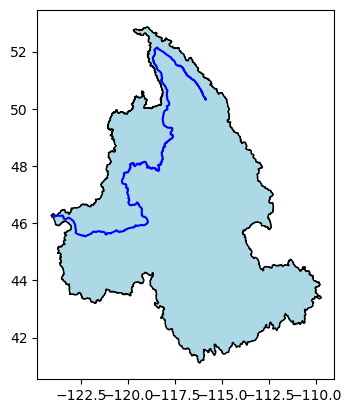

In [23]:
# plot the Columbia river basin and the Columbia River
fig, ax = plt.subplots()
col_basin.plot(ax=ax, color="lightblue", edgecolor="black")
col_river.plot(ax=ax, color="blue")
# col_river.interpolate(100).plot(ax=ax, color="red")
# col_river_aeqd.interpolate(1900000).to_crs(col_river.crs).plot(ax=ax, color="green");

In [24]:
# adapted from 
def line_to_segments(line, distance, segments):
    # Cuts a line in several segments at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:

        return gpd.GeoSeries(segments + [LineString(line)])
    coords = list(line.coords)
    for i, p in enumerate(coords):

        pd = line.project(Point(p))
        if pd == distance:
            segments.append(LineString(coords[: i + 1]))
            line = LineString(coords[i:])
            return line_to_segments(line, distance, segments)
        if pd > distance:
            cp = line.interpolate(distance)
            segments.append(LineString(coords[:i] + [(cp.x, cp.y)]))
            line = LineString([(cp.x, cp.y)] + coords[i:])

            return line_to_segments(line, distance, segments)

In [25]:
# project the river into an equidistant projection
lon_0, lat_0 = (
        col_basin.geometry[0].convex_hull.centroid.x,
        col_basin.geometry[0].convex_hull.centroid.y,
    )

# define aeqd projection centered on the centroid of the basin
aeq_crs = f"+proj=aeqd +lat_0={lat_0} +lon_0={lon_0}"

In [26]:
col_river_aeqd = col_river.to_crs(aeq_crs)
col_basin_grwl = grwl[grwl.within(col_basin.geometry[0])]

In [27]:
lines = line_to_segments(col_river_aeqd.unary_union, 10000, [])

reaches_gdf = gpd.GeoDataFrame(geometry=lines, crs=aeq_crs)
reaches_gdf["GNIS_Name"] = col_river_aeqd["GNIS_Name"].values[0]

In [28]:
unique_ids = []
RKm = []
for row, value in reaches_gdf.iterrows():
    # countList.append(value["GNIS_Name"])
    unique_ids.append("_".join(value["GNIS_Name"].split() + [str(row + 1)]))
    RKm.append(row * 10)

# bufferedReaches["reach_id"] = unique_ids

# add reach_id to filteredreaches
reaches_gdf["reach_id"] = unique_ids
reaches_gdf["RKm"] = RKm

In [12]:
reaches_gdf = reaches_gdf.sjoin_nearest(col_basin_grwl.to_crs(aeq_crs), how="left",distance_col="distance", max_distance=10000)

reaches_gdf.rename(
    columns={
        "width_max_": "WidthMax",
        "width_mean": "WidthMean",
        "width_min_": "WidthMin"
    },
    inplace=True,
)

In [13]:
reaches_gdf = reaches_gdf.sort_values(by=["reach_id", "WidthMean"], ascending=[False, False])
reaches_gdf = reaches_gdf.drop_duplicates(subset="reach_id")

In [14]:
# replace all null values in the Width* with 30
buffered_reaches = reaches_gdf.copy()
buffered_reaches.fillna({'WidthMax': 30, 'WidthMean': 30}, inplace=True)
# buffered_reaches = buffered_reaches.sort_values(by=["reach_id", "WidthMean"], ascending=[False, False])

# bufferedReaches = filteredReachLines.copy()
# bufferedReaches['geometry'] = bufferedReaches.geometry.buffer(filteredReachLines['WIDTH95']/2 + 120, resolution=5)
buffered_reaches["geometry"] = buffered_reaches.geometry.buffer(
    buffered_reaches["WidthMean"] / 2 + 120,
    # filteredReachLines_["WidthMax"] / 2 + 120,
    resolution=5,
    # cap_style=3
)

In [15]:
buffered_reaches.explore(column="WidthMean")

In [16]:
# save buffered reaches to file
buffered_reaches = buffered_reaches.to_crs(col_basin.crs)
reaches_gdf = reaches_gdf.to_crs(col_basin.crs)


In [17]:
reaches_gdf.to_file(geopackage_fn, layer="Reaches", driver="GPKG")
buffered_reaches.to_file(geopackage_fn, layer="BufferedReaches", driver="GPKG")